# Diabetes regression training vs validation loss

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
d = load_diabetes()
len(d.data)

442

In [3]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [4]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [5]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [6]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1088.69 validation MSE 4337.15


In [7]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [8]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [9]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    27880.131
Epoch  100 MSE train loss     1577.831
Epoch  200 MSE train loss     1054.828
Epoch  300 MSE train loss      722.420
Epoch  400 MSE train loss      511.705
Epoch  500 MSE train loss      340.232
Epoch  600 MSE train loss      222.600
Epoch  700 MSE train loss      151.913
Epoch  800 MSE train loss      102.938
Epoch  900 MSE train loss       71.314
Epoch 1000 MSE train loss       50.224


### Track validation loss and compare with plot, demonstrate overfitting

In [10]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

In [11]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

Epoch    0 MSE train loss    27926.936   test loss    33745.129
Epoch  100 MSE train loss     1582.381   test loss     4534.623
Epoch  200 MSE train loss     1108.024   test loss     4681.855
Epoch  300 MSE train loss      802.279   test loss     4999.889
Epoch  400 MSE train loss      571.750   test loss     5000.369
Epoch  500 MSE train loss      392.588   test loss     5178.365
Epoch  600 MSE train loss      273.072   test loss     5388.488
Epoch  700 MSE train loss      185.626   test loss     5409.833
Epoch  800 MSE train loss      132.876   test loss     5460.844
Epoch  900 MSE train loss       98.476   test loss     5465.192
Epoch 1000 MSE train loss       74.374   test loss     5530.125


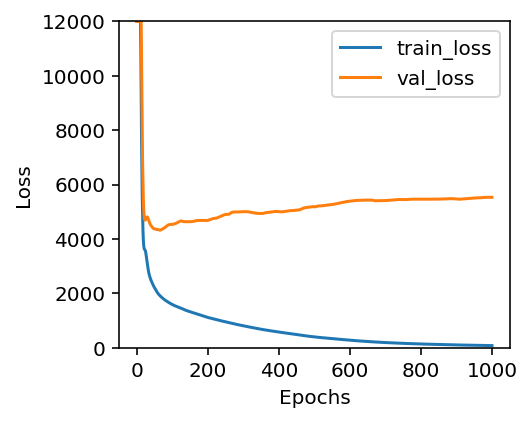

In [12]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000))

### Use weight decay to reduce overfitting

In [13]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

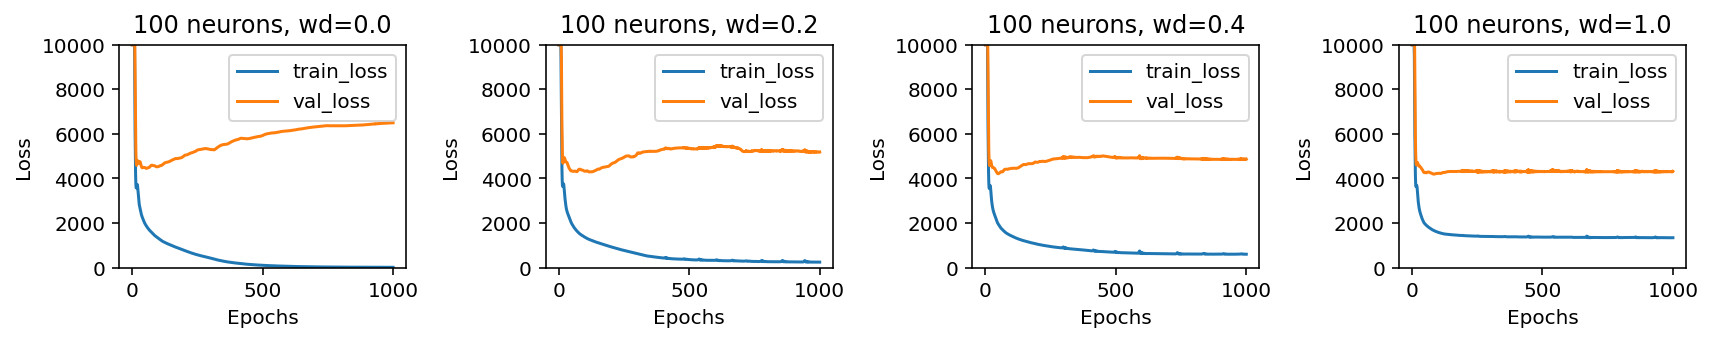

In [14]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.Tanh(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.15, nepochs=1000, weight_decay=wd,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [15]:
def train(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    27898.084   test loss    33712.684
Epoch  100 MSE train loss    19541.125   test loss    23243.744
Epoch  200 MSE train loss     8183.675   test loss    10541.724
Epoch  300 MSE train loss     3279.681   test loss     4684.834
Epoch  400 MSE train loss     2720.508   test loss     3795.325
Epoch  500 MSE train loss     2641.259   test loss     3734.327
Epoch  600 MSE train loss     2557.190   test loss     3749.180
Epoch  700 MSE train loss     2470.071   test loss     3766.652
Epoch  800 MSE train loss     2382.192   test loss     3801.534
Epoch  900 MSE train loss     2294.503   test loss     3856.434
Epoch 1000 MSE train loss     2208.199   test loss     3926.432
BEST MSE test loss 3733.865
MSE test loss 3733.865


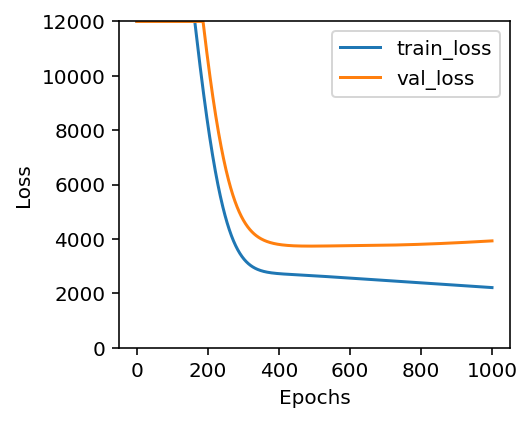

In [16]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.001, nepochs=1000,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))